## Feature engineering with pre-processed games

In this notebook we make heavy use of data munging, clustering and domain knwoledge to create a feature matrix. We then run some models on the putput and get some promising preliminary performance results.

In [275]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [18]:
with open('./../../../sc2games/PickledGames/iem_replays.p','rb') as corpus:
    iem_games = pickle.load(corpus)

The follwing class parses our high performance replay files into a collection of dataframes that are easily querried using the class methods and pandas' native tools. 

In [159]:
class Replay(object):
    def __init__(self, replay_dict, keep_source = False, positions = False):
        
        if keep_source == True:
            self.source = replay_dict
        
        self.context = replay_dict['context'] 
        
        # Parsing for unit data
        df_units = pd.DataFrame(data = replay_dict['objects']).T
        df_units.columns = columns=replay_dict['object_keys']
        
        df_units['x'], df_units['y'] = zip(*df_units['location'].values)
        df_units = df_units.drop(['location'], axis=1)
        df_units['name'] = df_units['name'].apply(lambda x:x.lower())
        
        # Parsing for player stats data
        df_stats = pd.DataFrame(data = replay_dict['player_stats'])
        df_stats.columns = columns=replay_dict['player_stat_keys']

        # Parsing for unit location updates (optional)
        if positions:
            df_positions = pd.DataFrame([
                {**pos_dict['positions'],
                 **{'frame':pos_dict['frame'], 'second':pos_dict['second']}} 
             for pos_dict in replay_dict['unit_positions']])

            df_positions.sort_values(by = 'frame', inplace = True)
            df_positions.fillna(method='ffill', inplace = True)

            unit_ids = sorted([col for col in df_positions.columns if type(col) == int])
            column_order = ['frame','second'] + unit_ids

            df_positions = df_positions[column_order]
            df_positions.reset_index(inplace = True, drop = True)
            self.positions = df_positions.sort_values(by = 'frame')
        
        # Parsing for unpgrades data
        df_upgrades = pd.DataFrame(replay_dict['upgrades'])
        df_upgrades['upgrade_type_name'] = df_upgrades['upgrade_type_name']\
        .apply(lambda x: x if 'SprayTerran' not in x and 'Reward' not in x else None).dropna()

        df_outcome = pd.DataFrame([{'result':player['result'],'pid':player['pid']} 
                                   for player in replay_dict['context']['players']])
        
        self.units = df_units.sort_values(by = 'finished_at')
        self.stats = df_stats.sort_values(by = 'frame')

        self.upgrades = df_upgrades.sort_values(by = 'frame')
        self.outcome = df_outcome
        
    def unit_plotter(self, seconds):
        """Plots the location of units 
        according to the unit possition data"""
        i = seconds//15
        plt.scatter(*zip(*[v for v in self.positions.loc[i].values[2:] if v == v]))
        plt.show()
        
    def get_units_end(self):
        """returns a series with tallies of units 
        for each player at the end of the game"""
        df = self.units
        df = df[df['died_at'].apply(lambda x:isinstance(x,type(None))).values]
        df = df[df['race']!= 'Neutral']
        
        x = df[['owner','race','name']]\
        .apply(lambda x: str(x['owner'])+x['race'][0]+'_'+ x['name'], axis=1)\
        .value_counts()
        return x
    
    def get_stats_end(self):
        """returns a series with the stats 
        for each player at the end of the game"""
        df = self.stats.tail(3)
        
        p1 = df[df['pid']==1].tail(1).to_dict()
        p2 = df[df['pid']==2].tail(1).to_dict()

        p1 = {'1'+'_'+key:list(p1[key].values())[0] for key in p1.keys()}
        p2 = {'2'+'_'+key:list(p2[key].values())[0] for key in p2.keys()}

        return pd.Series({**p1,**p2}).drop(['1_frame','2_frame'])
    
    def get_upgrades_end(self):
        return self.upgrades.drop(['frame','second'], axis=1)\
                .groupby('pid')\
                .apply(lambda x: pd.get_dummies(x, prefix=[str(x['pid'].iloc[0])]))\
                .drop(['pid'], axis=1)\
                .sum()

    def get_outcome(self):
        return pd.Series({**self.neat_outcome[0], **self.neat_outcome[1]})
    
    def get_end_state(self):
        return pd.concat([self.get_units_end(), 
                          self.get_stats_end(), 
                          self.get_outcome()])

We prototype the following using the first 100 games of the IEM corpus of replays.

In [175]:
#first_100_games = [Replay(iem_games[i]) for i in range(100)]
first_100_games = [Replay(game) for game in iem_games if game['context']['real_type'] == '1v1']

In [176]:
first_100_games[0].get_upgrades_end().head()

1_ShieldWall                     1.0
1_Stimpack                       1.0
1_TerranInfantryArmorsLevel1     1.0
1_TerranInfantryArmorsLevel2     1.0
1_TerranInfantryWeaponsLevel1    1.0
dtype: float64

In [177]:
first_100_games[0].get_units_end().head()

1T_scv            68
2T_scv            59
1T_marine         34
1T_supplydepot    13
1T_medivac        12
dtype: int64

In [178]:
first_100_games[0].get_stats_end().head()

1_minerals_collection_rate                2351
1_minerals_current                          63
1_minerals_used_in_progress_army          1150
1_minerals_used_in_progress_economy          0
1_minerals_used_in_progress_technology       0
dtype: int64

We colate these results into dataframes:

In [179]:
upgrades_df = pd.DataFrame([game.get_upgrades_end() for game in first_100_games]).fillna(0)
upgrades_df.head()

,1_AdeptPiercingAttack,1_BansheeCloak,1_BansheeSpeed,1_BlinkTech,1_Burrow,1_CarrierLaunchSpeedUpgrade,1_CentrificalHooks,1_Charge,1_ChitinousPlating,1_DarkTemplarBlinkUpgrade,...,2_ZergGroundArmorsLevel3,2_ZergMeleeWeaponsLevel1,2_ZergMeleeWeaponsLevel2,2_ZergMeleeWeaponsLevel3,2_ZergMissileWeaponsLevel1,2_ZergMissileWeaponsLevel2,2_ZergMissileWeaponsLevel3,2_overlordspeed,2_zerglingattackspeed,2_zerglingmovementspeed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [180]:
stats_df = pd.DataFrame([game.get_stats_end() for game in first_100_games])
stats_df.head()

,1_minerals_collection_rate,1_minerals_current,1_minerals_used_in_progress_army,1_minerals_used_in_progress_economy,1_minerals_used_in_progress_technology,1_pid,1_vespene_collection_rate,1_vespene_current,1_vespene_used_in_progress_army,1_vespene_used_in_progress_economy,...,2_minerals_current,2_minerals_used_in_progress_army,2_minerals_used_in_progress_economy,2_minerals_used_in_progress_technology,2_pid,2_vespene_collection_rate,2_vespene_current,2_vespene_used_in_progress_army,2_vespene_used_in_progress_economy,2_vespene_used_in_progress_technology
0,2351,63,1150,0,0,1,985,555,400,0,...,118,400,0,0,2,627,1144,0,0,0
1,335,360,200,0,150,1,44,104,0,0,...,110,150,50,100,2,335,32,150,0,0
2,2239,230,950,0,0,1,1030,346,450,0,...,1490,200,0,600,2,649,1578,0,0,0
3,2183,217,750,0,0,1,492,19,250,0,...,62,600,0,0,2,447,34,200,0,0
4,2883,105,900,0,0,1,828,48,300,0,...,353,750,0,0,2,649,121,250,0,0


In [181]:
first_100_games[0].get_upgrades_end()

1_ShieldWall                     1.0
1_Stimpack                       1.0
1_TerranInfantryArmorsLevel1     1.0
1_TerranInfantryArmorsLevel2     1.0
1_TerranInfantryWeaponsLevel1    1.0
1_TerranInfantryWeaponsLevel2    1.0
1_TerranVehicleWeaponsLevel1     1.0
2_ShieldWall                     1.0
2_Stimpack                       1.0
2_TerranInfantryArmorsLevel1     1.0
2_TerranInfantryArmorsLevel2     1.0
2_TerranInfantryWeaponsLevel1    1.0
2_TerranInfantryWeaponsLevel2    1.0
2_TerranVehicleWeaponsLevel1     1.0
dtype: float64

In [187]:
def get_end_location_of_units(game):
    try:
        runits = game.units
    except:
        runits = Replay(game).units
        
    runits = runits[(runits['died_at'].apply(lambda x:isinstance(x,type(None)))) 
                    & (runits['race'] != 'Neutral')][['name','x','y','owner']]
    return runits

def plot_game_end_states(games):
    games = games[0:min(16, len(games))]
    plt.figure(figsize=(20,10))
    for i,game in enumerate(games):
        r = Replay(game)
        plt.subplot(4,4, i+1)
        runits = get_end_location_of_units(r).sort_values(by='owner')
        plt.scatter(runits['x'], runits['y'], c=runits['owner'], alpha = 0.4)
        plt.title(['Purple','Yellow'][r.outcome[r.outcome['result'] == 'Win']['pid'].values[0]-1] + ' Won')
    plt.tight_layout(pad=1)
    plt.show()

    Player 1 == PURPLE
    Player 2 == YELLOW

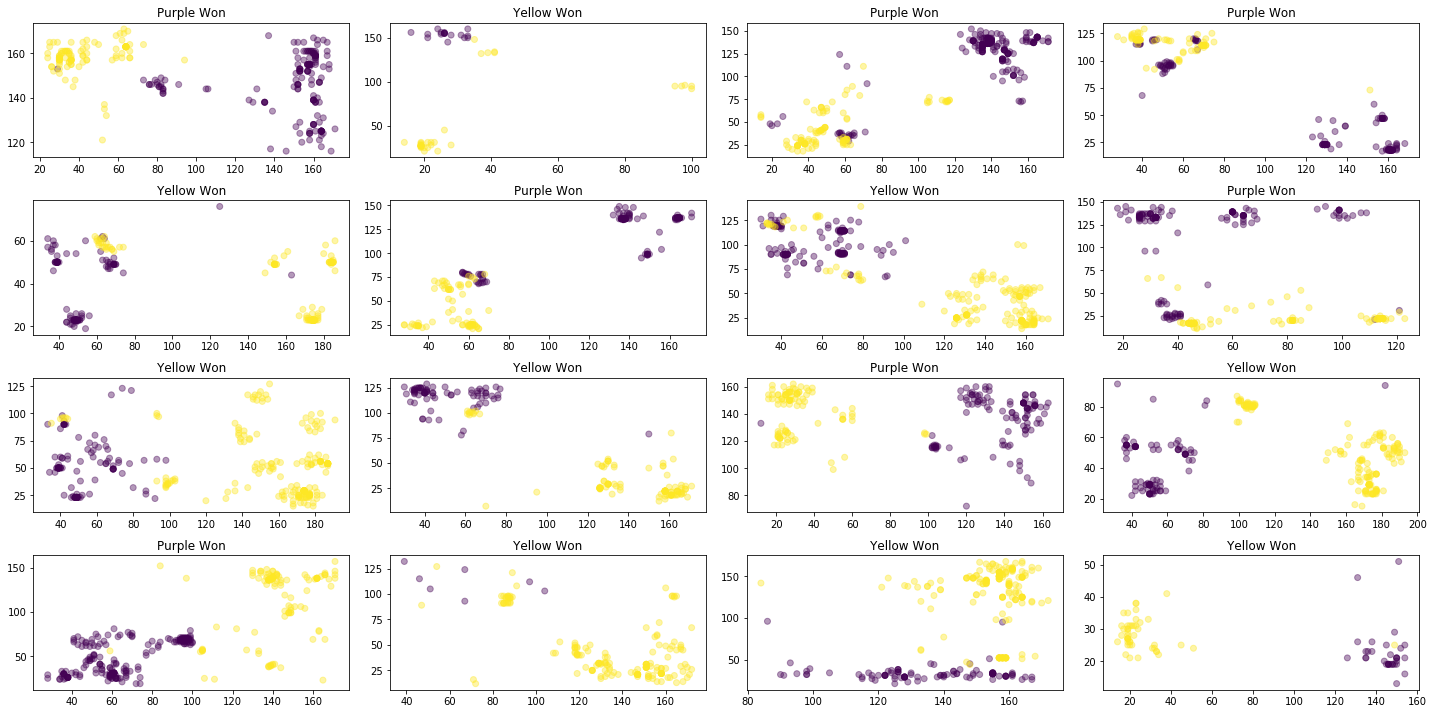

In [188]:
plot_game_end_states(iem_games)

### Using clustering to quantify "being overrun" by looking at homogeneity.

In [189]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, homogeneity_completeness_v_measure

homogeneity_completeness_v_measure

# The terran marine has a range of 5.
# Tanks a range of between 7 and 13.
# Tempests have the longest range in the game at 15.

# We call initialize DBSCAN to extend a cluster 
# if it sees 4 or more units within a 10 tile radius.

unit_clusterer = DBSCAN(eps=10,min_samples=5)

runits = get_end_location_of_units(iem_games[6])
predicted_clusters = unit_clusterer.fit_predict(runits[['x','y']])

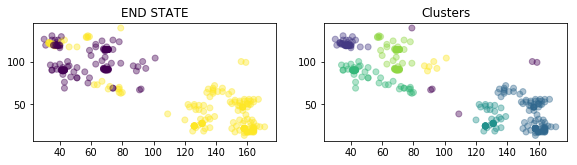

In [233]:
plt.figure(figsize=(20,10))
plt.subplot(4,4,1)
plt.scatter(runits['x'], runits['y'], c=runits['owner'], alpha = 0.4)
plt.title('END STATE')

plt.subplot(4,4,2)
plt.scatter(runits['x'], runits['y'], c=predicted_clusters, alpha = 0.4)
plt.title('Clusters')

plt.show()

In [1]:
2.25 + (1.25**3)

4.203125

for every cluster then we can ask: Who had the most units in the cluster
    what kind of units were they?
    how many and of what kind where the enemy's units in the same cluster

In [190]:
unit_info_json = pd.read_json('/usr/local/lib/python3.6/site-packages/sc2reader/data/unit_info.json')\
.apply(lambda x:x['Protoss'] if x['Protoss'] == x['Protoss'] 
       else x['Terran'] if x['Terran'] == x['Terran'] else x['Zerg'], axis=1)

In [234]:
def assess_cluster(df):
    x = df.groupby('owner')['name'].value_counts()
    x = pd.DataFrame(x)
    x['supply'] = [unit_info_json[name[1]].get('supply',0) for name in x.index]
    x['is_army'] = [unit_info_json[name[1]].get('is_army', False) for name in x.index]
    x['is_worker'] = [unit_info_json[name[1]].get('is_worker', False) for name in x.index]
    x['minerals'] = [unit_info_json[name[1]].get('minerals', 0) for name in x.index]
    x['vespene'] = [unit_info_json[name[1]].get('vespene', 0) for name in x.index]
    x['military_power'] = x.apply(lambda x: x['is_army']*x['supply']*x['name'], axis = 1)
    x['economic_importance'] = x.apply(lambda x: int(not(x['is_army']))\
                                       *((x['minerals']/50)+(x['vespene']/25))\
                                       *x['name'], axis = 1)
    x = x.groupby('owner').sum()[['military_power','economic_importance']]
    x.index.name = None
    for i in [1,2]:
        if i not in x.index:
            x = pd.concat([x.T,pd.Series({'military_power':0,'economic_importance':0}, name=i)], axis=1).T
    return x
    
assess_cluster(runits[predicted_clusters==5])

,economic_importance,military_power
1,2.5,0.0
2,0.0,0.0


In [192]:

# If both armies are similar, both economies are at low risk
# If one army^2 is more than double the other^2 then the economy is at high risk, low risk
# If one army^2 is more than triple the other^2 then the economy is at extreme risk, and safe


In [193]:
def classify_cluster_outcome(df):
    x = assess_cluster(df)
    x['military_power^2'] = x['military_power'].apply(lambda x:x**2)
    
    power_ratio = (x['military_power^2'][1]+0.001)/(x['military_power^2'][2]+0.001)
    
    if power_ratio < 1/3:
        risk = {'1_extreme_risk':x['economic_importance'][1],
                '2_safe':x['economic_importance'][2]}
    elif power_ratio < 1/2:
        risk = {'1_high_risk':x['economic_importance'][1],
                '2_low_risk':x['economic_importance'][2]}
    elif power_ratio < 2:
        risk = {'1_mid_risk':x['economic_importance'][1],
                '2_mid_risk':x['economic_importance'][2]}
    elif power_ratio < 3:
        risk = {'1_low_risk':x['economic_importance'][1],
                '2_high_risk':x['economic_importance'][2]}
    else:
        risk = {'1_safe':x['economic_importance'][1],
                '2_extreme_risk':x['economic_importance'][2]}
        
    risk['1_military_power'] = x['military_power'][1]
    risk['2_military_power'] = x['military_power'][2]
    return risk

In [194]:
def cluster_analysis(units, predicted_clusters):
    return pd.DataFrame([classify_cluster_outcome(units[predicted_clusters==j]) 
                    for j in list(set(predicted_clusters))]).sum()

In [195]:
def game_risk_analysis(game):
    unit_clusterer = DBSCAN(eps=10,min_samples=5)
    units = get_end_location_of_units(game)
    predicted_clusters = unit_clusterer.fit_predict(units[['x','y']])
    return cluster_analysis(units, predicted_clusters)

In [196]:
%%time
risk_df = pd.DataFrame([game_risk_analysis(game) for game in first_100_games]).fillna(0)

CPU times: user 3min 42s, sys: 179 ms, total: 3min 42s
Wall time: 3min 42s


In [197]:
risk_df.head()

,1_extreme_risk,1_high_risk,1_low_risk,1_mid_risk,1_military_power,1_safe,2_extreme_risk,2_high_risk,2_low_risk,2_mid_risk,2_military_power,2_safe
0,0.0,0.0,0.0,15.5,77.0,215.5,19.5,0.0,0.0,0.0,15.0,163.0
1,0.0,0.0,0.0,0.0,2.0,43.0,2.0,0.0,0.0,38.0,6.0,11.0
2,0.0,0.0,0.0,0.0,106.0,231.0,105.0,0.0,0.0,51.5,37.0,0.0
3,0.0,0.0,0.0,0.0,79.5,96.5,90.5,0.0,0.0,0.0,16.0,0.0
4,18.0,0.0,0.0,0.0,11.0,97.0,0.0,0.0,0.0,0.0,66.0,105.0


In [203]:
player_1_outcome = [game.outcome['result'][0] for game in first_100_games]

In [209]:
##### from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(penalty='l1', C=0.1)

def assess_model(model,X = risk_df, y = player_1_outcome):
    return accuracy_score(y,cross_val_predict(model,X,y,cv=10))

for df in [risk_df, stats_df, upgrades_df]:
    print(assess_model(lr,X=df))

0.97619047619
0.854761904762
0.521428571429


In [211]:
from sklearn.ensemble import  RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)

for df in [risk_df, stats_df, upgrades_df]:
    print(assess_model(rfc,X=df))

0.945238095238
0.857142857143
0.583333333333


----

In [213]:
pd.Series(player_1_outcome).value_counts()

Win     228
Loss    192
dtype: int64

In [215]:
from sklearn.svm import SVC
from sklearn.ensemble.bagging import BaggingClassifier

svc = SVC(kernel='poly', degree=1)
assess_model(svc)

0.96666666666666667

In [218]:
X = pd.concat([risk_df,stats_df], axis=1)
assess_model(svc, X=X)

0.98571428571428577

In [219]:
blr = BaggingClassifier(lr, n_estimators=100)
rfc = RandomForestClassifier(n_estimators=100)
bsvc = BaggingClassifier(svc, n_estimators=100)

In [221]:
assess_model(blr, X=X)

0.98571428571428577

In [222]:
assess_model(rfc, X=X)

0.9642857142857143

In [220]:
assess_model(bsvc, X=X)

0.98095238095238091

In [227]:
import numpy as np
np.random.seed = 2

print('blr')
for df in [risk_df, stats_df, upgrades_df,X]:
    print(assess_model(blr,X=df))
    
print('\nrfc')
for df in [risk_df, stats_df, upgrades_df,X]:
    print(assess_model(rfc,X=df))

print('\nbsvc')
for df in [risk_df, upgrades_df,X]:
    print(assess_model(bsvc,X=df))


blr
0.97619047619
0.852380952381
0.504761904762
0.985714285714

rfc
0.942857142857
0.85
0.585714285714
0.954761904762

bsvc
0.97619047619
0.533333333333
0.978571428571


In [282]:
blr_pred = cross_val_predict(blr, X, player_1_outcome,cv=50)
rfc_pred = cross_val_predict(rfc, stats_df, player_1_outcome,cv=50)
bsvc_pred = cross_val_predict(bsvc, X, player_1_outcome,cv=50)

In [283]:
voting = pd.DataFrame([blr_pred, rfc_pred, bsvc_pred]).applymap(lambda x:1 if x == 'Win' else 0).mean().apply(lambda x: 'Win' if (x > 0.5) else 'Loss')
voting.head()

0     Win
1    Loss
2     Win
3     Win
4    Loss
dtype: object

In [284]:
accuracy_score(player_1_outcome,voting)

0.98095238095238091

In [288]:
from sklearn.naive_bayes import MultinomialNB
mnnb = MultinomialNB()
print(assess_model(mnnb, X=X))

mnnb_pred = cross_val_predict(mnnb, X, player_1_outcome, cv = 50)

0.895238095238


In [289]:
bmnnb = BaggingClassifier(mnnb, n_estimators=1000, max_features= 0.7)
bmnnb_pred = cross_val_predict(bmnnb, df.fillna(0), player_1_outcome, cv = 5, n_jobs=4)
accuracy_score(player_1_outcome,bmnnb_pred)

0.90714285714285714

In [238]:
def voter(votes):
    votes_win, votes_loose = 0,0
    for vote in votes:
        if vote[0] == 'Win':
            votes_win += vote[1]
            votes_loose += 1-vote[1]
        else:
            votes_win += 1-vote[1]
            votes_loose += vote[1]
    if votes_win > votes_loose:
        outcome = 'Win'
    else:
        outcome = 'Loss'
    return outcome

In [280]:
best = 0

for i in range(1,1000):
    w = np.random.rand(3)
    votes = pd.DataFrame([blr_pred, rfc_pred, bsvc_pred]).T\
    .apply(lambda x: voter([(x[0],w[0]),(x[1],w[1]),(x[2],w[2])]), axis = 1)
    
    sc = accuracy_score(player_1_outcome,votes)
    if sc > best:
        best = sc
        print(w,sc)

[ 0.30602179  0.41720889  0.99246437] 0.978571428571
[ 0.7958017   0.64268197  0.62835207] 0.988095238095


In [290]:
best = 0
for i in range(1,1000):
    w = np.random.rand(4)
    votes = pd.DataFrame([blr_pred, rfc_pred, bsvc_pred, bmnnb_pred]).T\
    .apply(lambda x: voter([(x[0],w[0]),(x[1],w[1]),(x[2],w[2]),(x[3],w[3])]), axis = 1)
    
    sc = accuracy_score(player_1_outcome,votes)
    if sc > best:
        best = sc
        print(w,sc)

[ 0.54135185  0.72296023  0.62581665  0.91036272] 0.907142857143
[ 0.57252944  0.22118492  0.69011241  0.74704923] 0.954761904762
[ 0.75923091  0.26908584  0.2936898   0.72783188] 0.961904761905
[ 0.82969456  0.3444865   0.87161886  0.34183294] 0.983333333333
[ 0.83941431  0.78713198  0.64085324  0.35409537] 0.985714285714


In [291]:
from sklearn.linear_model import SGDClassifier

In [332]:
sgd = SGDClassifier(max_iter=5000, tol=0.000001)

In [333]:
assess_model(sgd, X = risk_df)

0.96666666666666667

In [334]:
assess_model(sgd, X = stats_df)

0.74761904761904763

In [335]:
assess_model(sgd, X = upgrades_df)

0.52857142857142858

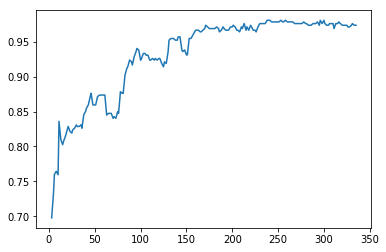

In [252]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(), X, player_1_outcome,
                                                         train_sizes=np.linspace(.01,1,200), cv=5)
plt.plot(train_sizes,pd.DataFrame(valid_scores).T.mean().values)
plt.show()

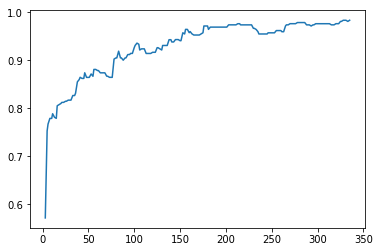

In [253]:
train_sizes, train_scores, valid_scores = learning_curve(SVC(kernel='linear'), X, player_1_outcome,
                                                         train_sizes=np.linspace(.01,1,200), cv=5)
plt.plot(train_sizes,pd.DataFrame(valid_scores).T.mean().values)
plt.show()

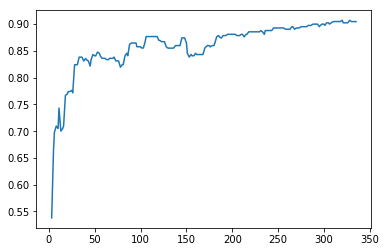

In [271]:
train_sizes, train_scores, valid_scores = learning_curve(SVC(kernel='poly', degree=2), X, player_1_outcome,
                                                         train_sizes=np.linspace(.01,1,200), cv=5)
plt.plot(train_sizes,pd.DataFrame(valid_scores).T.mean().values)
plt.show()

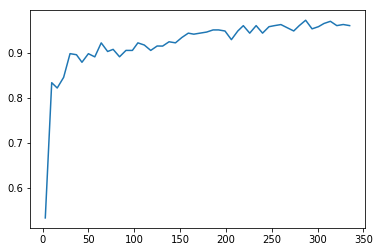

In [274]:
train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(n_estimators=100), X, player_1_outcome,
                                                         train_sizes=np.linspace(.01,1,50), cv=5)
plt.plot(train_sizes,pd.DataFrame(valid_scores).T.mean().values)
plt.show()

In [383]:
def plot_layers(game):
    runits = game.units
    layers = runits[(runits['owner'] != -1)]['name'].nunique()+1
    plt.figure(figsize=(20,20))

    xmin, xmax = runits['x'].min(),runits['x'].max()
    ymin, ymax = runits['y'].min(),runits['y'].max()

    for i,name in enumerate(list(runits['name'].unique())+['ALL']):
        plt.subplot(12,6, i+1)
        al = 0.8
        _runits = runits[(runits['name'] == name)]
        if name == 'ALL': 
            _runits = runits
            al = 0.4
        _ = plt.scatter(_runits['x'][_runits['owner']==1], _runits['y'][_runits['owner']==1], c='r',alpha = al)
        _ = plt.scatter(_runits['x'][_runits['owner']==2], _runits['y'][_runits['owner']==2], c='b', alpha = al)
        plt.title(name)
        plt.xlim(xmin-5, xmax+5)
        plt.ylim(ymin-5, ymax+5)

    plt.tight_layout(h_pad=1)
    plt.show()

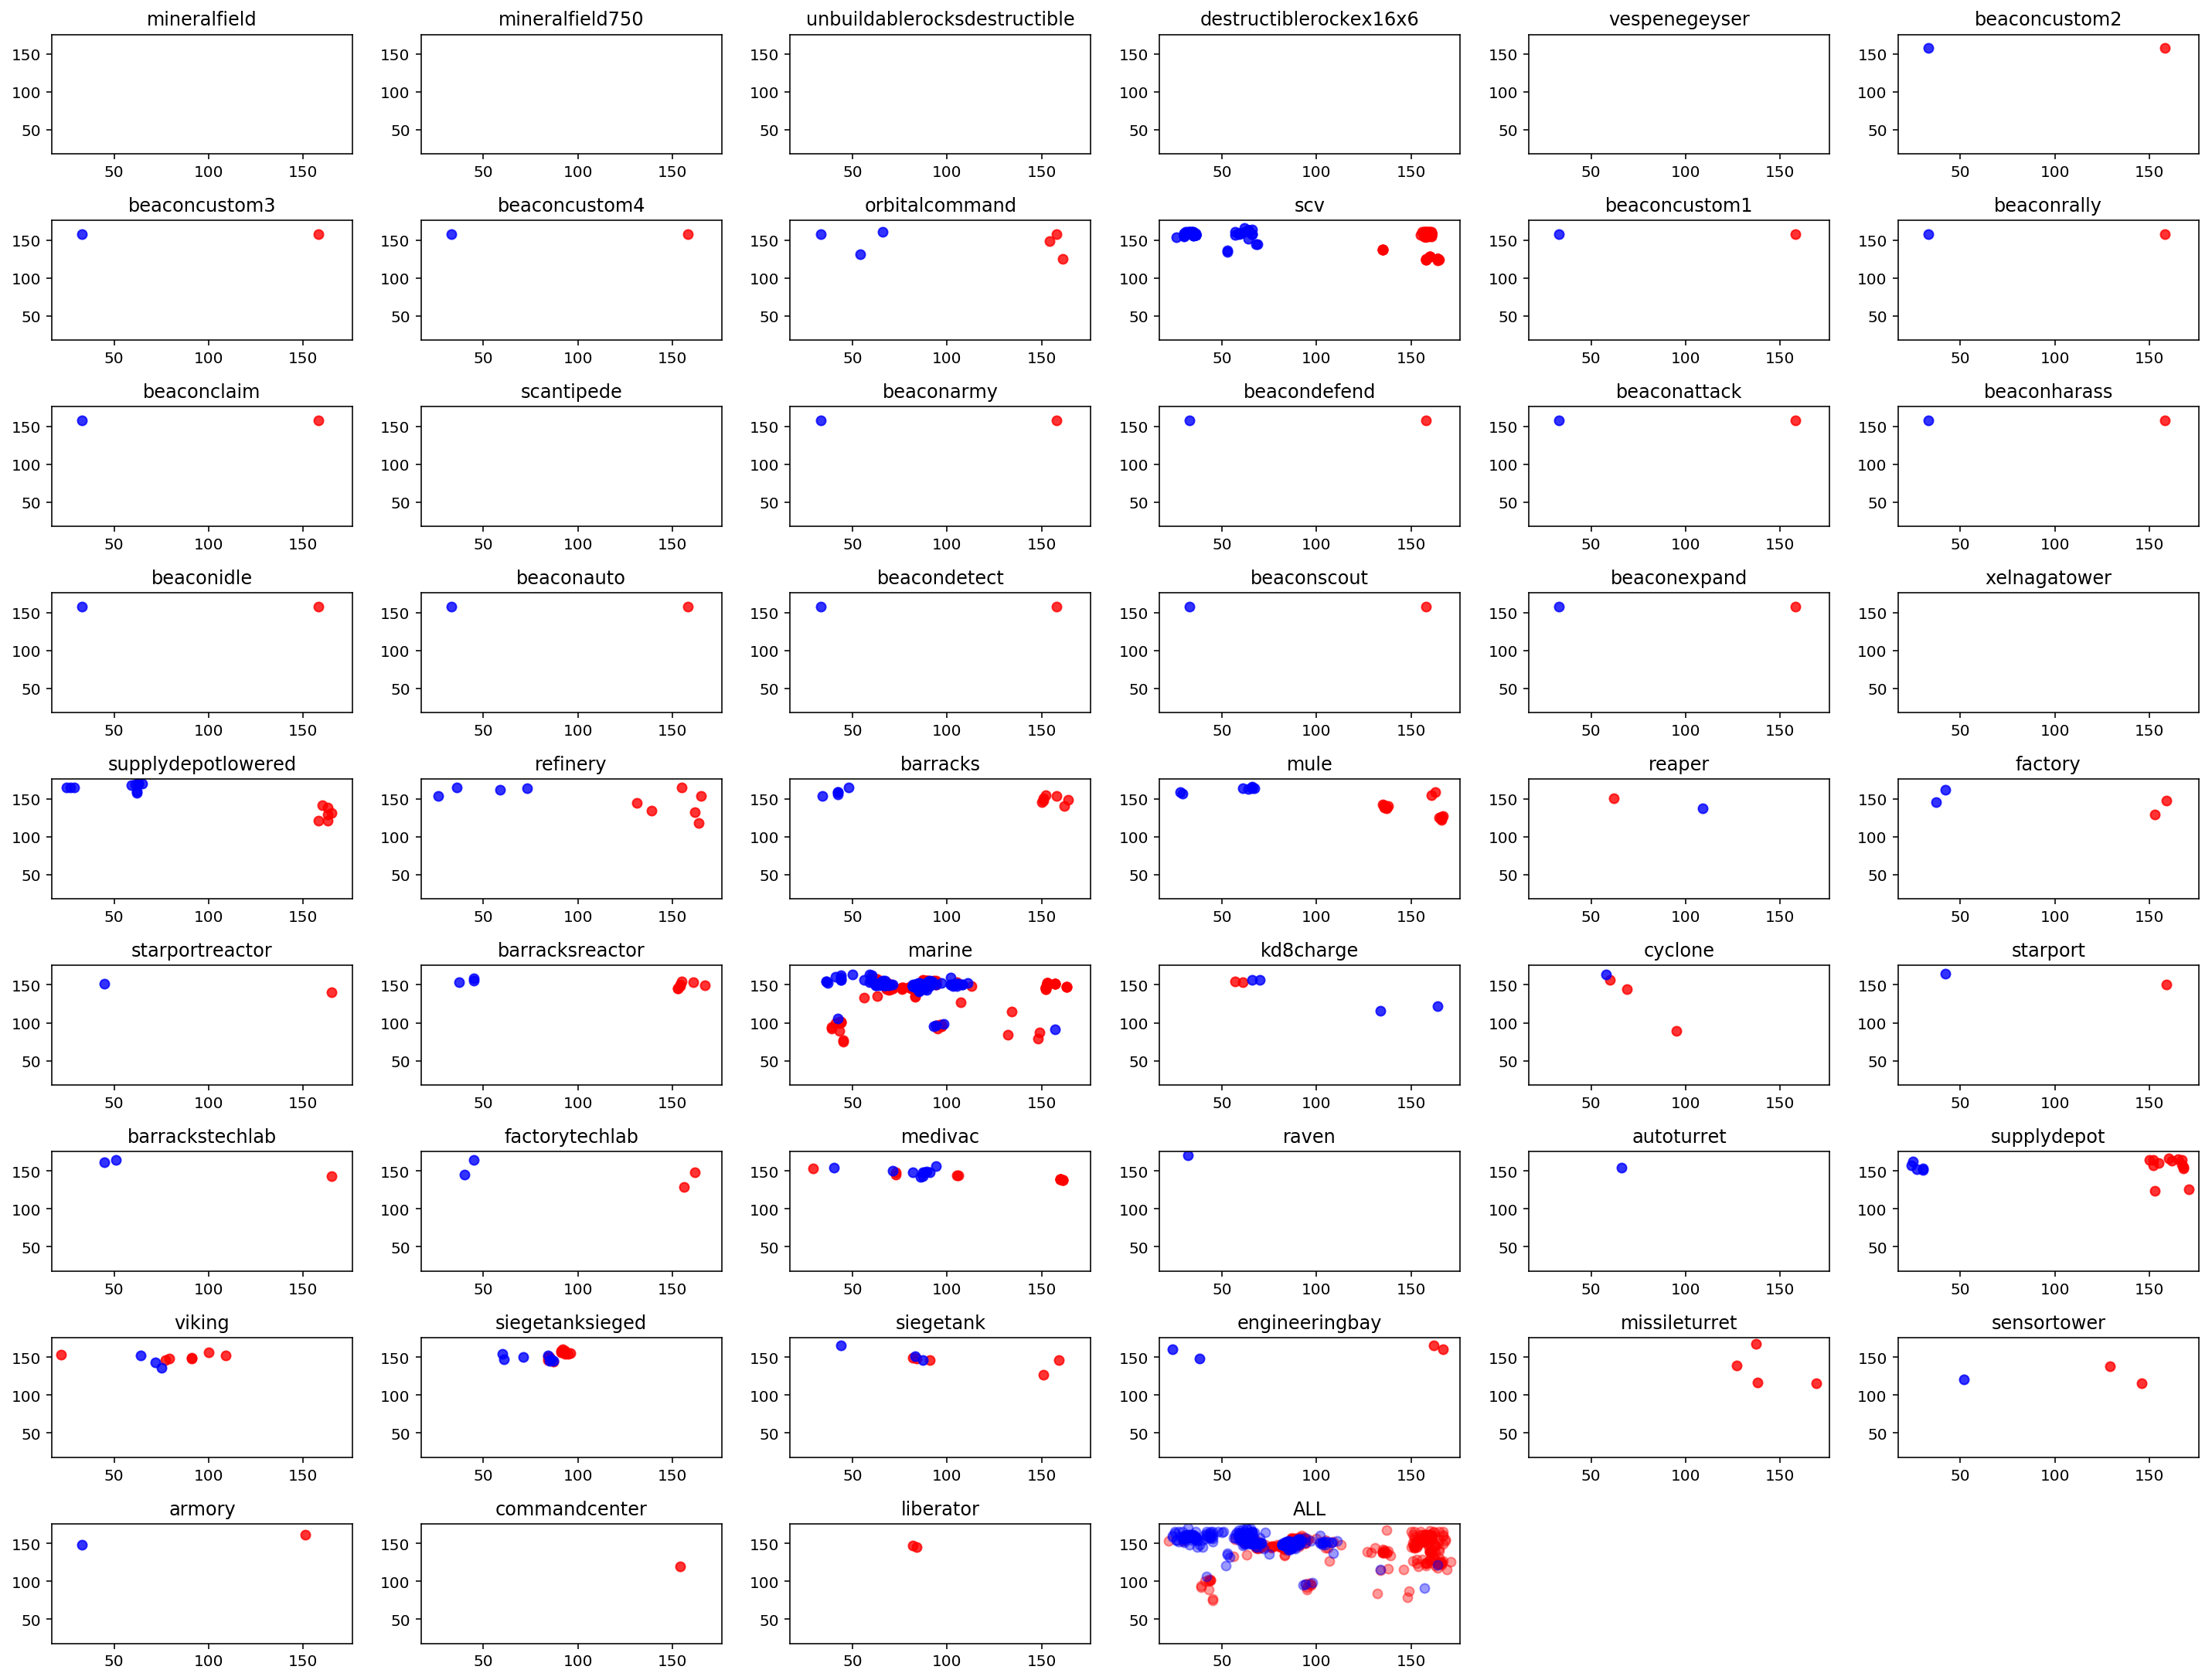

In [384]:
plot_layers(first_100_games[0])